Jupyter notebook to run the ML model for forecasting FEWS-NET food security 

Import packages 

In [29]:
import os
import random as python_random
import numpy as np
import matplotlib.pyplot as plt 
import datetime 
import pandas as pd
import seaborn as sns
os.chdir('C:\\Users\\tbr910\\Documents\\Forecast_action_analysis')
from ML_functions import *
#import tensorflow as tf`
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve


## feature selection 
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
import pydot
from graphviz import Source
from sklearn.feature_selection import RFE

## FEATURE EXPLANATION
import shap

shap.initjs() # load JS visualization code to notebook
#from keras.layers import Activation
#from keras.layers import BatchNormalization
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
# from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.layers import Dropout
#from scikeras.wrappers import KerasRegressor
#import lightgbm as lgb
#from tensorflow.keras import regularizers



folder paths 

In [30]:
DATA_FOLDER = 'C:\\Users\\tbr910\\Documents\\Forecast_action_analysis\\'
ML_FOLDER = 'C:\\Users\\tbr910\\Documents\\ML\\'
SE_FOLDER= 'C:\\Users\\tbr910\\Documents\\ML\\SE_data\\'
RESULT_FOLDER = 'C:\\Users\\tbr910\\Documents\\ML\\ML_results'

os.chdir(ML_FOLDER)

Set starting vars 

In [31]:
feature_engineering=True #without feature engineering the errors are much higher (almost 2x)   
forecast=True
fill_nans_target=True
leads=[0,1,2,4,8,12] # check: 12 lead creates quite some nan's in the training data 
random_split=False
counties=['Garissa','Isiolo','Mandera','Marsabit','Samburu','Tana River','Turkana','Wajir','Baringo','Kajiado','Kilifi','Kitui','Laikipia','Makueni','Meru','Taita Taveta','Tharaka','West Pokot','Lamu','Nyeri','Narok']

stats_df=pd.DataFrame(columns=('county', 'accuracy', 'accuracy_baseline', 'accuracy_baseline2','accuracy_lr', 'var_score','var_score_baseline','var_score_baseline2','var_score_lr', 'mae', 'mae_baseline', 'mae_baseline2','mae_lr', 'mse', 'mse_baseline', 'mse_baseline2', 'mse_lr', 'lead'))
features_df=pd.DataFrame(columns=('county', 'feature', 'feature_imp', 'lead'))             
features_df_full=pd.DataFrame()

Read impact dataset 

In [32]:
df=pd.read_excel('input_data.xlsx', index_col=0)
df.drop('GP',axis=1, inplace=True)






Append extra input data 

In [33]:
############################################# get extra socio economic data #############################################

######################  food prices ###################### https://data.humdata.org/dataset/wfp-food-prices-for-kenya

os.chdir(SE_FOLDER)
food_prices= pd.read_csv('food_prices.csv', index_col=0, header=1, delimiter=',')
# get header names from dataframe and simplify the names
food_prices.columns = food_prices.columns.str.replace('#','')
food_prices.columns = food_prices.columns.str.replace('+','_')
food_prices.rename(columns={'adm2_name':'county'}, inplace=True)

#keep only county, item_name, iten_price_flag, value_usd 
food_prices=food_prices[['county','item_name','item_price_flag','value_usd']]
# keep only rows with 'actual' and 'aggregate' price flags, and when the item_name contains 'Maize' 
food_prices=food_prices[((food_prices['item_price_flag']=='actual') | (food_prices['item_price_flag']=='aggregate')) & (food_prices['item_name'].str.contains('Maize'))]
#food_prices=food_prices[(food_prices['item_price_flag']=='actual') & (food_prices['item_name'].str.contains('Maize'))]

# rename value_usd to maize_price and drop item_name and item_price_flag
food_prices.rename(columns={'value_usd':'maize_price'}, inplace=True)
food_prices.drop(['item_name','item_price_flag'], axis=1, inplace=True)

#convert date to datetime index and set the day to first day in the month 
food_prices.index=pd.to_datetime(food_prices.index)
food_prices.index=food_prices.index.to_period('M').to_timestamp('D', 'start')


######################  population ###################### https://data.humdata.org/dataset/kenya-population-statistics-2019

# population= pd.read_excel('ken_admpop_2019.xlsx',sheet_name='ken_admpop_ADM1_2019',index_col=0, header=0)
# total_pop= population[['ADM1_NAME','T_TL']].set_index('ADM1_NAME')


# extract the feature names from the dataframe and convert to dataframe with nice names in new column 
feature_names=pd.DataFrame(df.columns, columns=['feature'])




The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


Main analysis 


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Garissa


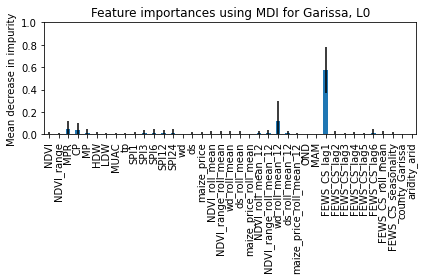

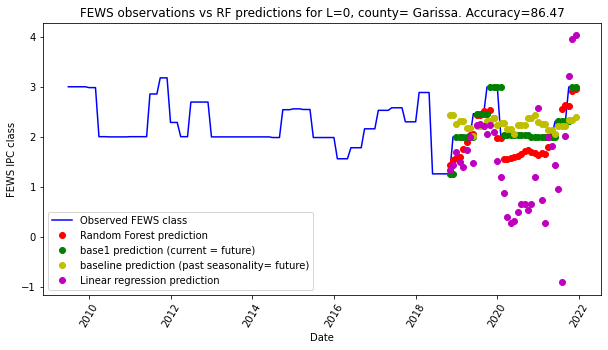

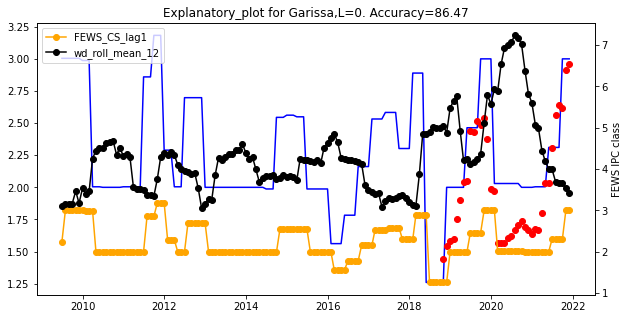

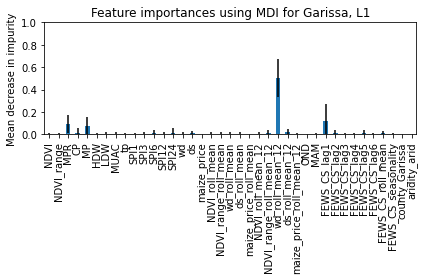

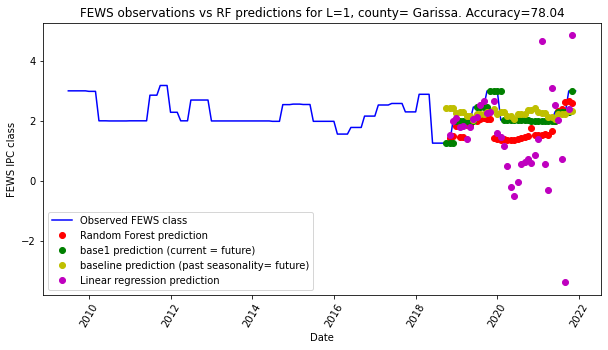

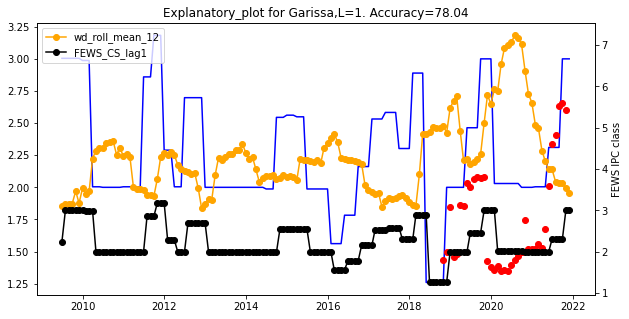

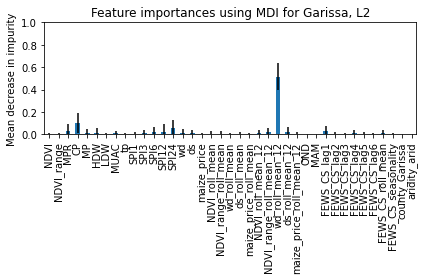

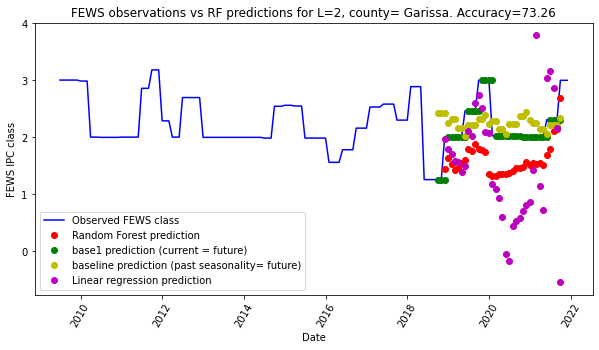

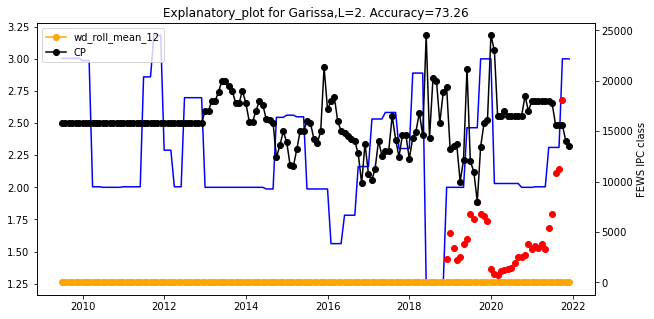

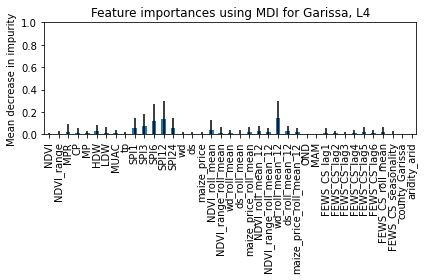

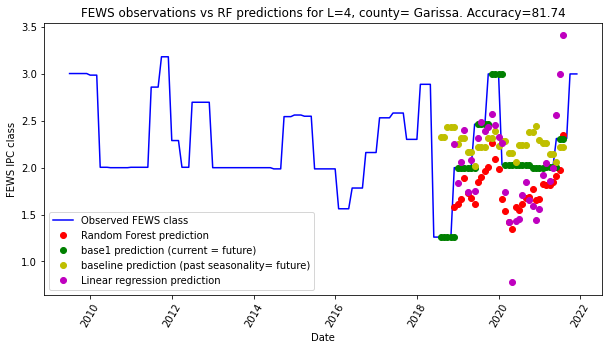

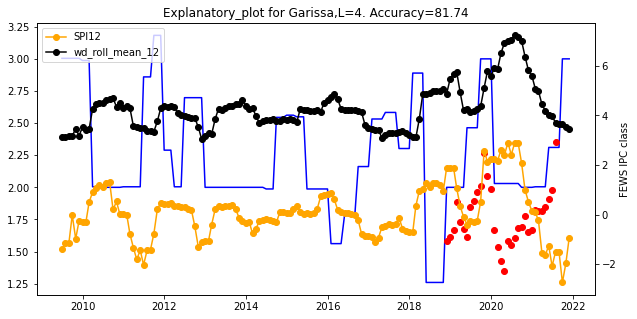

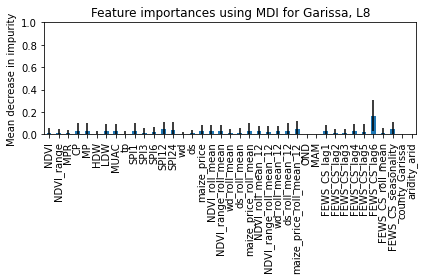

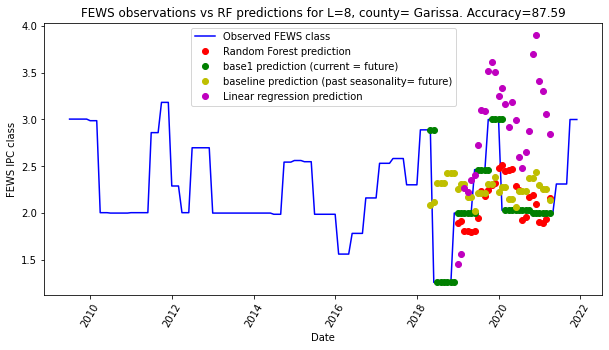

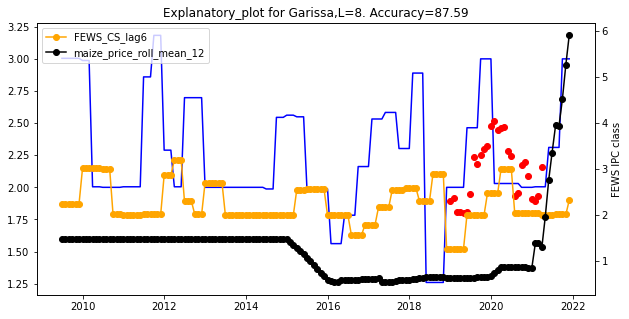

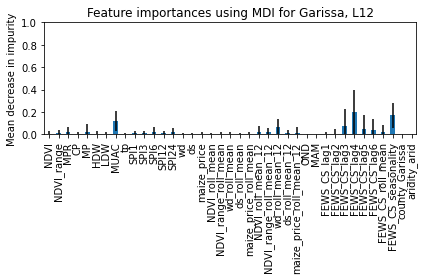

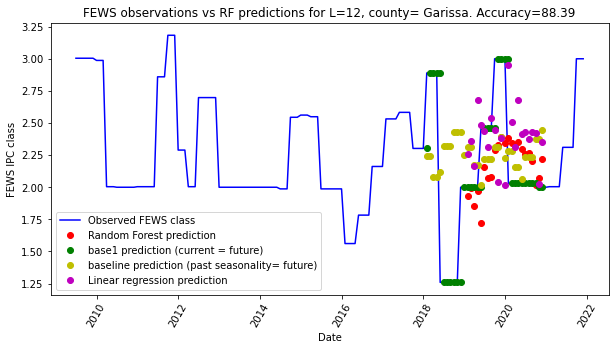

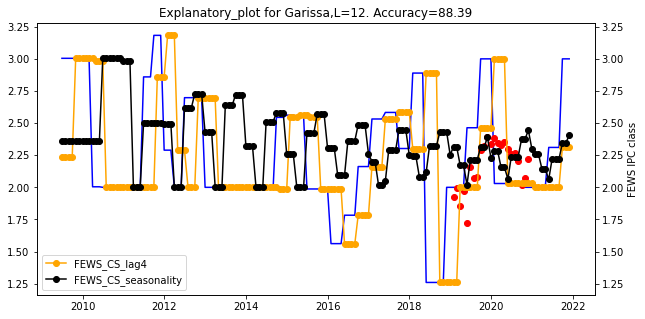

In [34]:
for county in counties[0:1]: 

    print(county)
    # construct the dataset 
    
    county=county
    features= df[df['county']==county]#['FEWS_CS']#[~df['FEWS_CS'].isnull()]

    ############################################# Merge extra SE data #############################################
    

    # merge food prices for a county with the features dataframe
    food_prices_county=food_prices[food_prices['county']==county]
    # sort index 
    food_prices_county.sort_index(inplace=True)
    # mean values for same datetime index 
    food_prices_county=food_prices_county.groupby(food_prices_county.index).mean()
    # print list of missing months in the index
    #print(food_prices_county.index[~food_prices_county.index.isin(features.index)])
    
    # add food prices to features as a new column, for the same datetime index. Keep all rows in features, even if there is no food price data for that month
    features=features.merge(food_prices_county, how='left', left_index=True, right_index=True)



    ############################################# NAN values processing #############################################

    
    # linear imputation FEWS in between the not nan values 
    #
    
    if fill_nans_target==False:
        features=features.dropna(subset=['FEWS_CS'])

    else:
        #features['FEWS_CS']=features['FEWS_CS'].interpolate(method='time',limit_area='inside')
        features['FEWS_CS']=features['FEWS_CS'].fillna(method="ffill")
    

    # create dataframe column called 'FEWS_CS_baseline2' with baseline2 float numbers (based on min and max of FEWS_CS)
    #features['FEWS_CS_baseline2']= np.baseline2.uniform(features['FEWS_CS'].min(), features['FEWS_CS'].max(), size=len(features))
    

    # fill na for indicators (debatable!)
    NDMA_indicators=['MPR', 'CP', 'MP', 'HDW', 'LDW', 'MUAC'] #'GP'

    #make new SE_indicators variable based on whether there is SE data for the county or not
    if food_prices_county.empty:
        SE_indicators= []
    else:
        SE_indicators= ['maize_price']

    all_SE_indicators=NDMA_indicators+SE_indicators


    for ind in all_SE_indicators:
        features[ind].fillna((features[ind].mean()), inplace=True)

    # explore the data and correlations with some fancy plots 

    # pairplot with axis labels all around, and only the plots with highest correlations 
    # sns.pairplot(features, kind="reg", diag_kind="kde", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
    


    #################################################### feature engineering ####################################################
   

    if feature_engineering==True:
        # add rolling mean for 4 months and 12 months
        #     
        features['NDVI_roll_mean']=features['NDVI'].rolling(window=4).mean().shift(1)
        features['NDVI_range_roll_mean']=features['NDVI_range'].rolling(window=4).mean().shift(1)
        features['NDVI_crop_roll_mean']=features['NDVI_crop'].rolling(window=4).mean().shift(1)
        features['wd_roll_mean']=features['wd'].rolling(window=4).mean().shift(1)
        features['ds_roll_mean']=features['ds'].rolling(window=4).mean().shift(1)
        features['maize_price_roll_mean']=features['maize_price'].rolling(window=4).mean().shift(1)

        features['NDVI_roll_mean_12']=features['NDVI'].rolling(window=12).mean().shift(1)
        features['NDVI_range_roll_mean_12']=features['NDVI_range'].rolling(window=12).mean().shift(1)
        features['NDVI_crop_roll_mean_12']=features['NDVI_crop'].rolling(window=12).mean().shift(1)
        features['wd_roll_mean_12']=features['wd'].rolling(window=12).mean().shift(1)
        features['ds_roll_mean_12']=features['ds'].rolling(window=12).mean().shift(1)
        
        # fill nan values that came out of rolling
        features['NDVI_roll_mean'].fillna((features['NDVI_roll_mean'].mean()), inplace=True)
        features['NDVI_range_roll_mean'].fillna((features['NDVI_range_roll_mean'].mean()), inplace=True)
        features['NDVI_crop_roll_mean'].fillna((features['NDVI_crop_roll_mean'].mean()), inplace=True)
        features['wd_roll_mean'].fillna((features['wd_roll_mean'].mean()), inplace=True)
        features['ds_roll_mean'].fillna((features['ds_roll_mean'].mean()), inplace=True)

        features['NDVI_roll_mean_12'].fillna((features['NDVI_roll_mean_12'].mean()), inplace=True)
        features['NDVI_range_roll_mean_12'].fillna((features['NDVI_range_roll_mean_12'].mean()), inplace=True)
        features['NDVI_crop_roll_mean_12'].fillna((features['NDVI_crop_roll_mean_12'].mean()), inplace=True)
        features['wd_roll_mean_12'].fillna((features['wd_roll_mean_12'].mean()), inplace=True)
        features['ds_roll_mean_12'].fillna((features['ds_roll_mean_12'].mean()), inplace=True)



        ######################### rolling operations for maize prices #########################
        # maize prices 
        if food_prices_county.empty:
            pass
        else:
            features['maize_price_roll_mean_12']=features['maize_price'].rolling(window=12).mean().shift(1)
            
            # fill nan values that came out of rolling for maize price
            features['maize_price_roll_mean'].fillna((features['maize_price_roll_mean'].mean()), inplace=True)
            features['maize_price_roll_mean_12'].fillna((features['maize_price_roll_mean_12'].mean()), inplace=True)


    # drop nan values when whole column is nan (CROP column)
    features.dropna(axis=1, how='all', inplace=True)

    # drop nan values (values outside of the date range of the FEWS data)
    features=features[~features['FEWS_CS'].isna()] #keep only not nan values 


    #################################################### Extract MAM and OND seasons ####################################################
    features['month']=features.index.month
    features['day']=features.index.day
    features['year']=features.index.year

    # add OND and MAM rainy season
    # OND --> months 10,11,12, flag in a new column with boolean values
    features['OND']=((features['month']==10) | (features['month']==11) | (features['month']==12))
    # MAM --> months 3,4,5, flag in a new column with boolean values
    features['MAM']=((features['month']==3) | (features['month']==4) | (features['month']==5))

    # make a seperate dataframe with day, month, year columns 
    features_date=features[['day','month','year']]

    # drop day, month, year columns from features
    features.drop(['day','month','year'], axis=1, inplace=True)


    if feature_engineering==True:


        #################################################### feature engineering for FEWS ####################################################
        features['FEWS_CS_lag1']=features['FEWS_CS'].shift(1)
        features['FEWS_CS_lag1'].fillna((features['FEWS_CS_lag1'].mean()), inplace=True)


        # FEWS_CS lags

        features['FEWS_CS_lag2']=features['FEWS_CS'].shift(2)
        features['FEWS_CS_lag3']=features['FEWS_CS'].shift(3)
        features['FEWS_CS_lag4']=features['FEWS_CS'].shift(4)
        features['FEWS_CS_lag5']=features['FEWS_CS'].shift(5)
        features['FEWS_CS_lag6']=features['FEWS_CS'].shift(6)

        # create new variables from rolling mean of existing features, where the preceding 4 months are used to calculate the mean. Do not include the current month 
        features['FEWS_CS_roll_mean']=features['FEWS_CS'].rolling(window=4).mean().shift(1)

        # fill nan values which are created by the rolling mean in the first 4 months with the mean of the whole column
        features['FEWS_CS_roll_mean'].fillna((features['FEWS_CS_roll_mean'].mean()), inplace=True)
        # same for the lags 
        
        features['FEWS_CS_lag2'].fillna((features['FEWS_CS_lag2'].mean()), inplace=True)
        features['FEWS_CS_lag3'].fillna((features['FEWS_CS_lag3'].mean()), inplace=True)
        features['FEWS_CS_lag4'].fillna((features['FEWS_CS_lag4'].mean()), inplace=True)
        features['FEWS_CS_lag5'].fillna((features['FEWS_CS_lag5'].mean()), inplace=True)    
        features['FEWS_CS_lag6'].fillna((features['FEWS_CS_lag6'].mean()), inplace=True)
        
        # create a seasonality column, which represents the mean for that specific month (e.g. January), only including the previous months that are already observed (requires a check!)
        features['FEWS_CS_seasonality']=features.groupby(features.index.month)['FEWS_CS'].transform(lambda x: x.shift(1).expanding().mean())
        # fill nan values of FEWS_CS_seasonality with the mean of the whole column
        features['FEWS_CS_seasonality'].fillna((features['FEWS_CS_seasonality'].mean()), inplace=True)

    # One-hot encode the data using pandas get_dummies
    features = pd.get_dummies(features) 
  
    # save labels 
    labels=features['FEWS_CS']  
    features['FEWS_base']=features['FEWS_CS']

    # Remove the labels from the features
    features= features.drop('FEWS_CS', axis = 1)# axis 1 refers to the columns


    
    # drop county_Garissa and aridity_arid columns
    # corr=features.drop(['county_Garissa','aridity_arid'], axis=1)
    # corr=corr.corr()
    # plt.figure(figsize=(20,20))
    # sns.heatmap(corr,annot=False, fmt='.2f', cmap='coolwarm', xticklabels=corr.columns, yticklabels=corr.columns)
    # plt.title('Correlation matrix')
    # #save in plots folder in results
    # plt.savefig(RESULT_FOLDER + '/plots/correlation_matrix.png')

    # plt.show()



      
    ############################################### Feature selection ###############################################


    # # feature selection with selectkbest test
    #features_kbest = SelectKBest(f_regression, k=10).fit_transform(features, labels)
    #features_kbest = pd.DataFrame(features_kbest)
    
    # this function will take in X, y variables 
    # with criteria, and return a dataframe
    # with most important columns
    # based on that criteria
    # def featureSelect_dataframe(X, y, criteria, k):

    #     # initialize our function/method
    #     reg = SelectKBest(criteria, k=k).fit(X,y)
        
    #     # transform after creating the reg (so we can use getsupport)
    #     X_transformed = reg.transform(X)

    #     # filter down X based on kept columns
    #     X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    #     # return that dataframe
    #     return X

    # features = featureSelect_dataframe(features, labels, mutual_info_regression, 10)
    
    
    




    ################################### saving features ###################################  
    feature_list = list(features.columns)

    if forecast==True: 
        # implement leads of 1,4 and 8, 12 months for all features except for the FEWS_base
        # shift the features by 1,4 and 8 months, but not for the FEWS_base column
        # list of features except for FEWS_base
        
        for lead in leads: 
            features_l= features.copy()
            
            #cols_shift=list(features_l.columns)
            #cols_shift.remove('FEWS_base')
            
            # shift the FEWS_base column of the features dataframe by the lead (1,4,8,12) months. This moves the fews base from the future to the past to test the model in predicting the future
            features_l['FEWS_base']=features_l['FEWS_base'].shift(-lead)
            #remove the last X rows based on the lead
            if lead!=0:
                features_l=features_l.drop(features_l.index[-lead:])
        
            

            

            #################################################### split data into training and testing sets ####################################################
            train_features, test_features, train_labels, test_labels = train_test_split(features_l, features_l['FEWS_base'], test_size = 0.25,shuffle=False) #25% of the data used for testing (38 time steps)   random_state = 42. if baseline2 state is not fixed, performance is different each time the code is run.
            feature_list2=feature_list.copy()


            ############ create original fews_base values in shape of train_features and test_features ############# 
            fews_base_original=features['FEWS_base']
            # original fews_base with lead months dropped 
            fews_base_original_l=fews_base_original.copy()
            if lead!=0:
                fews_base_original_l=fews_base_original_l.drop(fews_base_original_l.index[-lead:])
            
            # original fews_base of the months present in train features 
            fews_base_original_train=fews_base_original_l.iloc[:len(train_features)]
            fews_base_original_test=fews_base_original_l.iloc[-len(test_features):]

            ############ create dates for training and testing set #############
            train_dates=pd.DataFrame({'day':train_features.index.day, 'month':train_features.index.month, 'year':train_features.index.year})
            test_dates=pd.DataFrame({'day':test_features.index.day, 'month':test_features.index.month, 'year':test_features.index.year})

            ############ convert to numpy arrays #############
            train_features_np = np.array(train_features)
            test_features_np = np.array(test_features)
            train_labels_np = np.array(train_labels)
            test_labels_np = np.array(test_labels)
            fews_base_original_np=np.array(fews_base_original)
            fews_base_original_l_np=np.array(fews_base_original_l)
            fews_base_original_train_np=np.array(fews_base_original_train)
            fews_base_original_test_np=np.array(fews_base_original_test)
            train_dates_np=np.array(train_dates)
            test_dates_np=np.array(test_dates)


            # Grid specs draft part

            # if grid_search==True: 
            #     tss = TimeSeriesSplit(n_splits = 5, test_size=5)# 10-fold cross validation

            #     for split, (train_index, test_index) in enumerate(tss.split(features_l)):
            #         # features
            #         train_features, test_features = features_l.iloc[train_index, :],features_l.iloc[test_index,:]
            #         # labels 
            #         train_labels, test_labels = labels_l.iloc[train_index], labels_l.iloc[test_index]
            #         # time 
            #         train_time, test_time = features_date_l.iloc[train_index, :],features_date_l.iloc[test_index,:]
            #         # convert to numpy array
            #         # features
            #         feature_list2=feature_list.copy()
            #         features_np = np.array(features_l)
            #         train_features_np=np.array(train_features)
            #         test_features_np=np.array(test_features)
            #         # time
            #         features_date_np=np.array(features_date_l)
            #         train_time_np=np.array(train_time)
            #         test_time_np=np.array(test_time)


            # from sklearn.model_selection import GridSearchCV
            # import warnings
            # warnings.filterwarnings("ignore") #ignore all warnings in this cell

            # parametergrid = { 
            #     'n_estimators': [25, 50, 100],
            #     'max_features': ['sqrt'],
            #     'max_depth' : [5,7,9],
            #     'random_state' : [18]
            # }

            # ## Grid Search function
            # CV_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parametergrid, cv= 4, scoring = 'neg_mean_squared_error')
            # CV_rf.fit(x_train, y_train)
            
            #rf = RandomForestClassifier(criterion = 'entropy', random_state = 42)
            
            
            ############################################### Baseline models ###############################################


            ######################## baseline 1: use the previous FEWS_base value (FEWS_CS_lag1) as prediction for the next time step in the test set

            fews_base_original_lag1=features['FEWS_CS_lag1']
            # original fews_base_lag1 with lead months dropped
            fews_base_original_lag1_l=fews_base_original_lag1.copy()
            if lead!=0:
                fews_base_original_lag1_l=fews_base_original_lag1_l.drop(fews_base_original_lag1_l.index[-lead:])
            

            # original fews_base_lag1 of the months present in train features
            base1_preds=fews_base_original_lag1_l.iloc[-len(test_features):]

            # Baseline errors, and display average baseline error
            base1_errors = abs(base1_preds - fews_base_original_test)

            ####################### baseline 2: create seasonality based on previously seen values in 
            # get seasonality from the features dataframe
            seasonality = features['FEWS_CS_seasonality']
            # seasonality with lead months dropped
            seasonality_l=seasonality.copy()
            if lead!=0:
                seasonality_l=seasonality_l.drop(seasonality_l.index[-lead:])
            
            # seasonality of the months present in test features
            base2_preds=seasonality_l.iloc[-len(test_features):]

            # Baseline errors, and display average baseline error
            base2_errors = abs(base2_preds - fews_base_original_test)



        
            ############################################### Drop fews base vars from datasets ###############################################
            train_features_np = np.delete(train_features_np, feature_list2.index('FEWS_base'), axis=1)
            test_features_np = np.delete(test_features_np, feature_list2.index('FEWS_base'), axis=1)
            feature_list2.remove('FEWS_base')

            ############################################### Linear Regression ###############################################

            regr = LinearRegression()
            regr.fit(train_features_np, train_labels)
            # Make predictions using the testing set
            lr_preds = regr.predict(test_features_np)
            lr_errors = abs(lr_preds - test_labels)

            ############################################### Random Forest ###############################################

            # Import the model we are using 
            rf = RandomForestRegressor(n_estimators = 1000,max_features='auto', n_jobs=-1, max_depth=5, min_samples_leaf=1, min_samples_split=2, random_state=40) # joris also uses max features  max_features='sqrt'
            

            # Train the model on training data
            model=rf.fit(train_features_np, train_labels)
            param_search = {'n_estimators' : [10, 100]}

            #gsearch = GridSearchCV(estimator=rf, cv=tss, param_grid=param_search)
            #gsearch.fit(train_features_np, train_labels)
            # Use the forest's predict method on the test data
            predictions = rf.predict(test_features_np) ## rf predictions for the months with lead ahead 
            
            # Calculate the absolute errors
            errors = abs(predictions - test_labels)

            ############################################### Evaluate ###############################################


            ############################# accuracy #############################
            # Calculate mean absolute percentage error (MAPE) 
            mape = 100 * (errors / test_labels)
            mape_baseline1= 100 * (base1_errors / test_labels)
            mape_baseline2= 100 * (base2_errors / test_labels)
            mape_lr= 100 * (lr_errors / test_labels)
            
            # Calculate and display accuracy
            accuracy = 100 - np.mean(mape)
            accuracy_baseline= 100 - np.mean(mape_baseline1)
            accuracy_baseline2= 100 - np.mean(mape_baseline2)
            accuracy_lr= 100 - np.mean(mape_lr)

            ############################# r2 score #############################

            # Explained variance score: 1 is perfect prediction
            var_score = r2_score(test_labels, predictions)
            var_score_baseline= r2_score(test_labels, base1_preds)
            var_score_baseline2= r2_score(test_labels, base2_preds)
            var_score_lr= r2_score(test_labels, lr_preds)

            ############################# mean absolute error #############################
            mae = mean_absolute_error(test_labels, predictions)
            mae_baseline= mean_absolute_error(test_labels, base1_preds)
            mae_baseline2= mean_absolute_error(test_labels, base2_preds)
            mae_lr= mean_absolute_error(test_labels, lr_preds)

            ############################# mean squared error #############################
            mse = mean_squared_error(test_labels, predictions)
            mse_baseline= mean_squared_error(test_labels, base1_preds)
            mse_baseline2= mean_squared_error(test_labels, base2_preds)
            mse_lr= mean_squared_error(test_labels, lr_preds)

            ############################# root mean squared error ############################# 
            rmse = np.sqrt(mean_squared_error(test_labels, predictions))
            rmse_baseline= np.sqrt(mean_squared_error(test_labels, base2_preds))
            rmse_baseline2= np.sqrt(mean_squared_error(test_labels, base2_preds))
            rmse_lr= np.sqrt(mean_squared_error(test_labels, lr_preds))


            
            # Visualize trees
        
            #Pull out one tree from the forest
            # os.chdir('C:\\Users\\tbr910\\Documents\\ML\\trees')
            # tree = rf.estimators_[5]# Export the image to a dot file
            # export_graphviz(tree, out_file = 'tree_%s.dot'%(county), feature_names = feature_list2, rounded = True, precision = 1)# Use dot file to create a graph
            # (graph, ) = pydot.graph_from_dot_file('tree_%s.dot'%(county))# Write graph to a png file
            # graph.write_png('tree_%s.png'%(county))
            

            
            # Get feature importances -->  computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.
            importances = list(rf.feature_importances_)# List of tuples with variable and importance
            std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
            feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list2, importances)]# Sort the feature importances by most important first
            
            # append featuer importances to df
            # make a dataframe with 3 columns: importance, county, lead. Importances is a np.array. Attach the county and lead to the array and then make a df from it.
            append= pd.DataFrame(importances, index=feature_list2, columns=['importance'])
            append['county']=county
            append['lead']=lead
            features_df_full=pd.concat([features_df_full, append], axis=0)



            
            # sort feature importances and print most important feature
            feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
            main_feature= feature_importances[0][0]
            feature_imp= feature_importances[0][1]

            
            ############################################### Plotting section ###############################################

                        
            ################# Plot feature importances #################
            # Make dir
            if not os.path.exists(RESULT_FOLDER+'\\plots'):
                os.makedirs(RESULT_FOLDER+'\\plots')

            os.chdir(RESULT_FOLDER+'\\plots')

            #  Variable importances
            forest_importances = pd.Series(importances, index=feature_list2)

            fig, ax = plt.subplots()
            forest_importances.plot.bar(yerr=std, ax=ax)

            
            ax.set_title("Feature importances using MDI for %s, L%s"%(county,lead))
            ax.set_ylabel("Mean decrease in impurity")
            ax.set_ylim(0,1)    
            fig.tight_layout()
            plt.savefig('Variable_Importances_%s_L%s.png'%(county,lead), dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

            ################# reconstruct dataframe with predictions #################
            months = test_dates_np[:, 1]
            days = test_dates_np[:, 0]
            years = test_dates_np[:, 2]# Column of dates
            test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]# Convert to datetime objects
            test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
            
            predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions, 'base1':base1_preds, 'base2': base2_preds,'lr':lr_preds}) # Dataframe with predictions and dates

            ################# Plot predictions #################
            
            ####### observations (target+ 2 most important features)
            #extract names from 2 most important features from feature importance tuples 
            feature1, feature2=feature_importances[0][0], feature_importances[1][0]
            obs=features[['FEWS_base',feature1,feature2]]


            ################# Convert predictions (rf+lr) to original time series (shift X rows forward based on lead time) #################
            # convert predictions to original time series
            predictions_data['prediction']=predictions_data['prediction'].shift(lead)
            predictions_data['lr']=predictions_data['lr'].shift(lead)
            fig, ax = plt.subplots(figsize=(10, 5))

            # Plot the actual values
            plt.plot(obs.index, obs['FEWS_base'], 'b-', label = 'Observed FEWS class')# Plot the predicted values
            
            # plot rf predictions
            plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'Random Forest prediction')
            # plot base predictions
            plt.plot(predictions_data['date'], predictions_data['base1'], 'go', label = 'base1 prediction (current = future)')
            plt.plot(predictions_data['date'], predictions_data['base2'], 'yo', label = 'baseline prediction (past seasonality= future)')
            #plot lr predictions
            plt.plot(predictions_data['date'], predictions_data['lr'], 'mo', label = 'Linear regression prediction')
            plt.xticks(rotation = '60'); 
            plt.xlabel('Date'); plt.ylabel('FEWS IPC class'); plt.title('FEWS observations vs RF predictions for L=%s, county= %s. Accuracy=%s'%(lead,county,round(accuracy, 2)));
            plt.legend(loc='best')
            plt.savefig('TS_%s_L%s.png'%(county,lead), dpi=300, bbox_inches='tight')
            plt.show() 
            plt.close()


            ################# Plot explanatory line graph #################


            fig, ax = plt.subplots(figsize=(10, 5))
            ax2=ax.twinx()
            
            # Plot the actual values
            ax.plot(obs.index, obs['FEWS_base'], 'b-', label = 'Observed FEWS class')# Plot the predicted values
            # plot rf predictions
            ax.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'random Forest prediction')
            
            # plot base predictions

            # plot features
            ax2.plot(obs.index, obs[feature1], 'o-', color='orange', label = feature1)# Plot the predicted values
            ax2.plot(obs.index, obs[feature2], 'o-', color='black', label = feature2)# Plot the predicted values
            
            plt.xticks(rotation = '60'); 
            plt.xlabel('Date'); plt.ylabel('FEWS IPC class'); plt.title('Explanatory_plot for %s,L=%s. Accuracy=%s'%(county,lead,round(accuracy, 2)));
            plt.legend()
            plt.savefig('Explanatory_plot_%s_L%s.png'%(county,lead), dpi=300, bbox_inches='tight')
            
            plt.show() 
            plt.close()








            # plot ROC curve 
            # Calculate the false positive rates and true positive rates
            # fpr, tpr, _ = roc_curve(test_labels, predictions)# Plot of a ROC curve for a specific class
            # plt.figure()
            # plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
            # plt.plot([0, 1], [0, 1], 'k--')# baseline2 guesses should fall in the middle
            # plt.xlim([0.0, 1.0])# Limit the graph
            # plt.ylim([0.0, 1.05])# Label the graph
            # plt.xlabel('False Positive Rate')
            # plt.ylabel('True Positive Rate')
            # plt.title('ROC curve for %s'%(county))
            # plt.legend(loc="lower right")
            # plt.savefig('ROC_%s.png'%(county))
            # plt.show()

            # make a evaluation dataframe (with baseline being the prediction based on observed clim)
            var_list= [county,round(accuracy, 2), round(accuracy_baseline, 2), round(accuracy_baseline2, 2), round(accuracy_lr,2), round(var_score, 2), round(var_score_baseline, 2),round(var_score_baseline2, 2), round(var_score_lr,2), round(mse,2), round(mse_baseline,2), round(mse_baseline2,2), round(mse_lr,2), round(mae,2), round(mae_baseline,2), round(mae_baseline2,2), round(mae_lr,2),lead]         
            stats_df.loc[len(stats_df), :] = var_list

            # make a features df
            var_list=[county, main_feature, feature_imp, lead]
            features_df.loc[len(features_df), :] = var_list












Summary plots 

invalid value encountered in reduce
invalid value encountered in reduce


ValueError: Axis limits cannot be NaN or Inf

<Figure size 720x360 with 0 Axes>

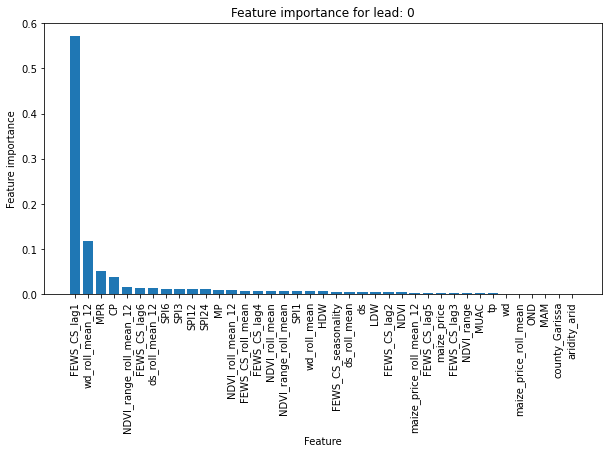

In [35]:
#make new folder for results
os.chdir(RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.makedirs(RESULT_FOLDER)
#save results in new folder     
stats_df.to_csv('stats_df2.csv')
features_df.to_csv('features_df2.csv')


#stats_df=pd.read_csv(RESULT_FOLDER+'\\stats_df2.csv')
# feature_df=pd.read_csv(RESULT_FOLDER+'\\features_df2.csv')



################################################# plots ###############################################


################### feature importance plot per lead time (averaged over counties) ###################

fig=plt.figure(figsize=(10, 5)) 
# plot feature importance per lead time
for lead in leads:
    # get feature importance for lead time
    features_df_lead=features_df_full[features_df_full['lead']==lead]
    # reset index 
    features_df_lead=features_df_lead.reset_index()
    # get mean feature importance per feature
    means=features_df_lead.groupby('index').mean()
    # rename importance column to mean
    means.rename(columns={'importance':'mean'}, inplace=True)
    # sort values
    means=means.sort_values(by='mean', ascending=False)
    # get stdev of feature importance per feature
    stdev=features_df_lead.groupby('index').std()
    # rename importance column to stdev
    stdev.rename(columns={'importance':'stdev'}, inplace=True)

    # merge stdev and mean on column with index as name 
    means=means.merge(stdev['stdev'], left_index=True, right_index=True)
    
    # plot feature importance per lead time
    plt.figure(figsize=(10, 5))
    plt.bar(means.index, means['mean'], yerr=means['stdev'], align='center', label='L=%s'%(lead))
    plt.xticks(rotation = '90');
    plt.xlabel('Feature'); plt.ylabel('Feature importance'); plt.title('Feature importance for lead: %s'%(lead));
    
    # x limite x-axis to 0 and 0.5 
    plt.ylim(0, means['stdev'].max()+0.2)
    plt.legend(loc='best')
    plt.savefig(RESULT_FOLDER+'\\feature_importance_lead_%s.png'%(lead), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()





############################################## evaluation plots ####################################
# convert all negative values in the df to zero 
column_names_eval = ['accuracy', 'accuracy_baseline', 'accuracy_baseline2', 'accuracy_lr', 'var_score', 'var_score_baseline', 'var_score_baseline2', 'var_score_lr', 'mse', 'mse_baseline', 'mse_baseline2', 'mse_lr', 'mae', 'mae_baseline', 'mae_baseline2', 'mae_lr']

for column in column_names_eval:
    stats_df.loc[stats_df[column]<0, column]=0

var_vars=['var_score', 'var_score_baseline', 'var_score_baseline2', 'var_score_lr']
mse_vars=['mse', 'mse_baseline', 'mse_baseline2', 'mse_lr']
mae_vars=['mae', 'mae_baseline', 'mae_baseline2', 'mae_lr']
accuracy_vars=['accuracy', 'accuracy_baseline', 'accuracy_baseline2', 'accuracy_lr']

# plot var scores (var_vars) for all counties for all leads 
for lead in leads:
    # subset stats_df for lead
    stats_df_lead=stats_df.loc[stats_df['lead']==lead]
    # melt the df to get a df with county, variable and var_score
    stats_df_lead_melt=pd.melt(stats_df_lead, id_vars=['county'], value_vars=var_vars, var_name='variable', value_name='var_score')
    # plot the df with seaborn
    fig=plt.figure(figsize=(10, 5))
    sns.barplot(x='county', y='var_score', hue='variable', data=stats_df_lead_melt)
    plt.title('Variance explained for lead %s'%(lead))
    plt.xticks(rotation=90)
    plt.tight_layout()
    # save plot in plots folder
    plt.savefig(RESULT_FOLDER+'\\plots\\R2_lead_%s.png'%(lead), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# plot mse scores (mse_vars) for all counties for all leads
for lead in leads:
    # subset stats_df for lead
    stats_df_lead=stats_df.loc[stats_df['lead']==lead]
    # melt the df to get a df with county, variable and mse
    stats_df_lead_melt=pd.melt(stats_df_lead, id_vars=['county'], value_vars=mse_vars, var_name='variable', value_name='mse')
    # plot the df with seaborn
    fig=plt.figure(figsize=(10, 5))
    sns.barplot(x='county', y='mse', hue='variable', data=stats_df_lead_melt)
    plt.title('Mean squared error for lead %s'%(lead))
    plt.xticks(rotation=90)
    plt.tight_layout()
    # save plot in plots folder
    plt.savefig(RESULT_FOLDER+'\\plots\\MSE_lead_%s.png'%(lead), dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# plot var_vars for all leads averaged over all counties 
# melt the df to get a df with lead, variable and var_score
stats_df_melt=pd.melt(stats_df, id_vars=['lead'], value_vars=var_vars, var_name='variable', value_name='var_score')
# plot the df with seaborn, lead on x-axis
fig=plt.figure(figsize=(10, 5))
sns.barplot(x='lead', y='var_score', hue='variable', data=stats_df_melt)
plt.title('Variance explained')
plt.xticks(rotation=90)
plt.ylim(0, stats_df_melt['var_score'].max())
plt.tight_layout()
# save plot in plots folder
plt.savefig(RESULT_FOLDER+'\\plots\\R2_all_leads.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()




SHAP values 

In [ ]:
# ####################################################################################### SHAP ###############################################################
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)


# explainer = shap.Explainer(model)
# shap_values = explainer(features)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

# # create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:,"SPI6"], color=shap_values)

# # summarize the effects of all the features
# shap.plots.beeswarm(shap_values)
    
# shap.plots.scatter(shap_values[:,"FEWS_CS_lag1"])

# shap.summary_plot(shap_values, features=features, feature_names=features.columns, plot_type="bar")



# # convert to list
# values=series.values
# values=list(values)
# #series = pd.read_csv('daily-total-female-births.csv', header=0, index_col=0)

# # transform the time series data into supervised learning
# # n_in=Number of lag observations as input (X). Values may be between [1..len(data)] Optional. Defaults to 1. 
# # n_out: Number of observations as output (y). Values may be between [0..len(data)-1]. Optional. Defaults to 1.
# data2 = series_to_supervised(values, 2,2) 
# # evaluate
# mae, y, yhat = walk_forward_validation(data, 12)
# n_test=12
# print('MAE: %.3f' % mae)
# # plot expected vs predicted
# pyplot.plot(y, label='Expected')
# pyplot.plot(yhat, label='Predicted')
# pyplot.legend()
# pyplot.show()


Script henrique 

In [ ]:

# #%% scriopt henrique 
# def calibration(X_origin,y_origin,type_of_model='RF', test_year = None):
#     X, y = shuffle(X_origin, y_origin, random_state=0)
#     if test_year == None:
#         # Shuffle and Split data
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#     else:
#         X_train, y_train = X.loc[X.index.get_level_values('time') != test_year], y.loc[y.index.get_level_values('time') != test_year]
#         X_test, y_test = X.loc[X.index.get_level_values('time') == test_year], y.loc[y.index.get_level_values('time') == test_year]
       
#     if type_of_model == 'RF':
#         model_rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1,
#                                           max_depth = 20, max_features = 'auto',
#                                           min_samples_leaf = 1, min_samples_split=2)
        
#         full_model_rf = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1,
#                                           max_depth = 20, max_features = 'auto',
#                                           min_samples_leaf = 1, min_samples_split=2)
        
        
        
        
        
        
        
        
        
        
        
        
        
        
#     elif type_of_model == 'lightgbm':
#         model_rf = Pipeline([
#             ('scaler', StandardScaler()),
#             ('estimator', lgb.LGBMRegressor(linear_tree= True, max_depth = 20, num_leaves = 50, min_data_in_leaf = 100, 
#                                             random_state=0, learning_rate = 0.01, n_estimators = 1000 ) )
#         ])
        
        
#         full_model_rf = Pipeline([
#             ('scaler', StandardScaler()),
#             ('estimator', lgb.LGBMRegressor(linear_tree= True, max_depth = 20, num_leaves = 50, min_data_in_leaf = 100, 
#                                             random_state=0, learning_rate = 0.01, n_estimators = 1000 ) )
#         ])
    
#     elif type_of_model == 'DNN':
#     #     	extra layer	batch	epoch	nodes	lr	dropout_value	best_epoch	R2	MAE	RMSE
#     #   31	True	          256	700	512	0.01	0.2	514	0.651	0.24641	0.34128
#     #   1	False	     1024	700	512	0.01	0.2	564	0.648	0.24794	0.34267
#     #   30	True	          256	700	512	0.005	0.2	635	0.648	0.24502	0.34266
#     # number of epochs 529 or 431
#         epochs_train = 441 #390
#         batch_size_train = 1024
#         nodes_size = 512
#         learning_rate_train = 0.01
#         dropout_train = 0.2
#         regul_value = 0
#         # =============================================================================
#         #      #   TRAIN model 
#         # =============================================================================
#         def create_model():
#             train_model = Sequential()
#             train_model.add(Dense(nodes_size, input_dim=len(X_train.columns), kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(regul_value))) 
#             train_model.add(BatchNormalization())
#             train_model.add(Activation('relu'))
#             train_model.add(Dropout(dropout_train))
    
#             train_model.add(Dense(nodes_size, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(regul_value)))
#             train_model.add(BatchNormalization())
#             train_model.add(Activation('relu'))
#             train_model.add(Dropout(dropout_train))
    
#             train_model.add(Dense(nodes_size, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(regul_value)))
#             train_model.add(BatchNormalization())
#             train_model.add(Activation('relu'))
#             train_model.add(Dropout(dropout_train))
           
#             train_model.add(Dense(nodes_size, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(regul_value)))
#             train_model.add(BatchNormalization())
#             train_model.add(Activation('relu'))
#             train_model.add(Dropout(dropout_train))
            
#             train_model.add(Dense(nodes_size, kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(regul_value)))
#             train_model.add(BatchNormalization())
#             train_model.add(Activation('relu'))
#             train_model.add(Dropout(dropout_train))
            
#             train_model.add(Dense(1, activation='linear'))
            
#             # compile the keras model
#             train_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate_train), metrics=['mean_squared_error','mean_absolute_error'])
#             return train_model
        
#         # Callbacks to monitor the performance of the optimization of the model and if there is any overfitting
#         # callback_model = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 100, restore_best_weights=True)
#         # mc = ModelCheckpoint('best_model_test.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
        
#         model_rf = Pipeline([
#             ('scaler', StandardScaler()),
#             ('estimator', KerasRegressor(model=create_model(), epochs= epochs_train, random_state = 0, batch_size=batch_size_train, verbose=0)) ]) #, callbacks=callback_model #, validation_split= 0.1, callbacks=[callback_model,mc]
        
#         model_fit = model_rf.fit(X_train, y_train)
        
#         # =============================================================================
#         #         # Entire full set model
#         # =============================================================================
#         full_model_rf = Pipeline([
#             ('scaler', StandardScaler()),
#             ('estimator', KerasRegressor(model=create_model(), epochs = epochs_train, random_state = 0, batch_size = batch_size_train, verbose=0)) ]) # validation_split= 0.1, callbacks=[callback_model_full, mc_full]
        
#         model_fit_full = full_model_rf.fit(X, y)

        
#     if type_of_model == 'DNN':
#         # Wrap up and plot graphs
#         model = model_fit
        
#         full_model = model_fit_full
        
#     else:
    
#         model = model_rf.fit(X_train, y_train)
        
#         full_model = full_model_rf.fit(X, y)
    
#     # Test performance
#     y_pred = model.predict(X_test)
#     df_y_pred = pd.DataFrame(y_pred, index = y_test.index, columns = [y_test.name]) 
    
#     # report performance
#     print(f'Results for model: {type_of_model}')
#     print("R2 on test set:", round(r2_score(y_test, y_pred),2))
#     print("Var score on test set:", round(explained_variance_score(y_test, y_pred),2))
#     print("MAE on test set:", round(mean_absolute_error(y_test, y_pred),5))
#     print("RMSE on test set:",round(mean_squared_error(y_test, y_pred, squared=False),5))
#     print("______")
    
#     y_pred_total = full_model.predict(X)
#     df_y_pred_total = pd.DataFrame(y_pred_total, index = y.index, columns = [y.name]) 
#     df_y_pred_total = df_y_pred_total.sort_index()
#     # Display error
#     plt.figure(figsize=(5,5), dpi=250) #plot clusters
#     plt.scatter(y_test, y_pred)
#     plt.plot(y_test, y_test, color = 'black', label = '1:1 line')
#     plt.ylabel('Predicted yield')
#     plt.xlabel('Observed yield')
#     plt.title('Scatter plot - test set')
#     plt.legend()
#     # plt.savefig('paper_figures/???.png', format='png', dpi=500)
#     plt.show()
    
#     # Display error
#     plt.figure(figsize=(5,5), dpi=250) #plot clusters
#     plt.scatter(y, y_pred_total)
#     plt.plot(y, y, color = 'black', label = '1:1 line')
#     plt.ylabel('Predicted yield')
#     plt.xlabel('Observed yield')
#     plt.title('Scatter plot - total set')
#     plt.legend()
#     # plt.savefig('paper_figures/???.png', format='png', dpi=500)
#     plt.show()
   
#     return df_y_pred, df_y_pred_total, model, full_model 